In [196]:
import numpy as np
import pandas as pd
import geopandas as gpd

from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.dates as mdates

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [197]:
dv_16 = pd.read_csv('./domestic_visitors/domestic_visitors_2016.csv')
dv_17 = pd.read_csv('./domestic_visitors/domestic_visitors_2017.csv')
dv_18 = pd.read_csv('./domestic_visitors/domestic_visitors_2018.csv')
dv_19 = pd.read_csv('./domestic_visitors/domestic_visitors_2019.csv')

fv_16 = pd.read_csv('./foreign_visitors/foreign_visitors_2016.csv')
fv_17 = pd.read_csv('./foreign_visitors/foreign_visitors_2017.csv')
fv_18 = pd.read_csv('./foreign_visitors/foreign_visitors_2018.csv')
fv_19 = pd.read_csv('./foreign_visitors/foreign_visitors_2019.csv')

In [198]:

festivals = pd.read_csv('./festivals/festivals.csv')
festivals['date'] = pd.to_datetime(festivals['date'])
festivals['holiday'] = festivals['holiday'].apply(lambda x: x.strip())
festivals['month'] = festivals['date'].dt.month

In [199]:
def format_data_type(datasets):
    datasets['date'] = pd.to_datetime(datasets['date'], format='%d-%m-%Y')
    datasets['visitors'] = datasets['visitors'].str.strip().replace('', np.nan).astype('float64')
    datasets['district'] = datasets['district'].str.strip().astype('category')

    return datasets

dv_16 = format_data_type(dv_16)
dv_17 = format_data_type(dv_17)
dv_18 = format_data_type(dv_18)
dv_19 = format_data_type(dv_19)

fv_16 = format_data_type(fv_16)
fv_17 = format_data_type(fv_17)
fv_18 = format_data_type(fv_18)
fv_19 = format_data_type(fv_19)

In [200]:
dv = pd.concat([dv_16, dv_17, dv_18, dv_19])
fv = pd.concat([fv_16, fv_17, fv_18, fv_19])

In [201]:
# dv.info()

In [202]:

dv['quarter']= 'Q' + dv['date'].dt.quarter.astype('str')
dv['month'] = dv['date'].dt.month_name()
dv['year'] = dv['date'].dt.year

In [203]:
domestic = dv_16, dv_17, dv_18, dv_19
foreign = fv_16, fv_17, fv_18, fv_19

def show_info(datasets):
    for i, _ in enumerate(datasets):
        print(f"{i+1}. General Information: ")
        print(_.info())
        print('-'*50)


# show_info(domestic)

### Question 1:
**List top 10 districts with highest number of visitors overall (2016-2019)**

In [204]:
visitors_district= dv.groupby(['district'])['visitors'].sum().reset_index()
visitors_district.sort_values(by='visitors', ascending=False, inplace=True)
visitors_district_10 = visitors_district[:10]

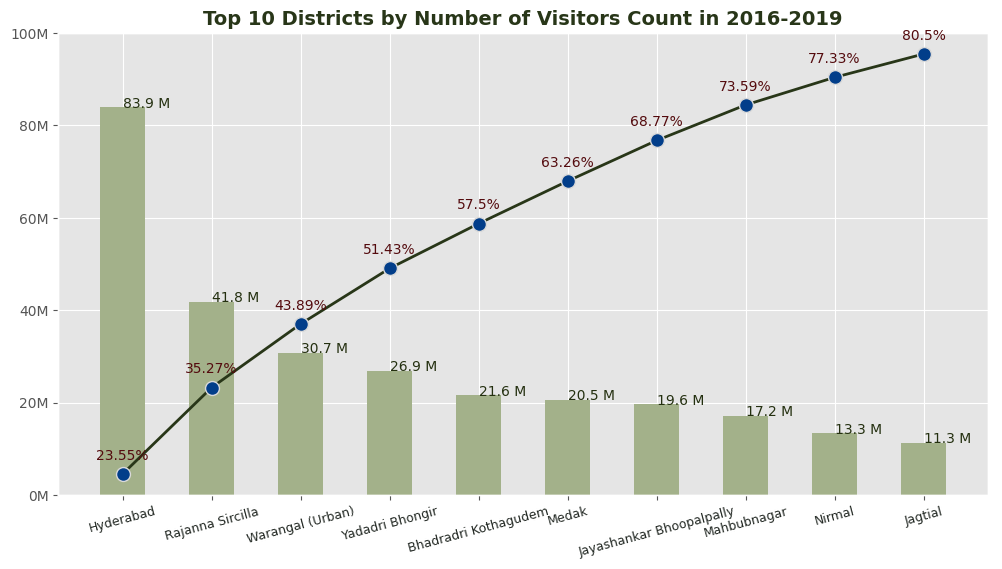

In [205]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()
ax2.yaxis.set_visible(False)
cumsum_pct = visitors_district['visitors'].cumsum() / visitors_district['visitors'].sum() * 100
cumsum_pct = cumsum_pct.round(2)

ax.bar(visitors_district_10['district'], visitors_district_10['visitors'], width=.5, color='#a3b18a')
ax2.plot(visitors_district_10['district'], cumsum_pct[:10], color='#283618', marker='o', markersize=10, markerfacecolor='#023e8a', markeredgecolor='#d9d9d9', linewidth=2)
# plt.bar_label(bar, labels=visitors_district_10['visitors'], label_type='edge',fmt={"%d"} , color='#073b4c', font={'size':12, 'weight':'bold'})

visitors = ['{:,}'.format(int(x)) for x in visitors_district_10['visitors'].values]
x = 0

for i, txt in enumerate(visitors_district_10['visitors']):
    ax.annotate('{:,.1f} M'.format(txt/1_000_000), (x, txt), color='#243010', fontsize=10, ha='left', va='baseline') 
    x+=1

for i, txt in enumerate(cumsum_pct[:10]):
    ax2.annotate(f'{txt}%', (i, txt+2), color='#540b0e', fontsize=10, ha='center', va='baseline')

ax.set_ylim(0, 100_000_000)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',') + 'M' ))
ax.set_xticklabels(visitors_district_10['district'], rotation=15, fontdict={'fontsize': 9, 'color': '#222823'})

plt.title('Top 10 Districts by Number of Visitors Count in 2016-2019', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': '#283618'})
plt.show()

### Question 2 and 3:
**List down the top 3 and bottom 3 districts based on compounded annual growth rate (CAGR) of visitors between 2016-2019.**

In [217]:
df = dv.groupby(['district', 'year'])['visitors'].sum().unstack().reset_index()
# Sort the dataframe by district name

years = len([2016, 2017, 2018, 2019])

cagr = ((df[2019] / df[2016]) ** (1/years) - 1) * 100
# Add CAGR as a new column to the dataframe


for i, c in enumerate(cagr):
    y = years
    if c == np.inf:
        y-=1
        cagr[i] = ((df.iloc[i][2019] / df.iloc[i][2017]) ** (1/y) - 1) * 100
#If the number of tourists in 2016 is 0, 
#then the CAGR is calculated by the number of tourists in 2017 and 2019
#The year for calculating CAGR is 2017 and 2019 (3 years)

df['CAGR'] = np.round(cagr, 2)
df.sort_values(by='CAGR', ascending=False, inplace=True)
df.dropna(inplace=True)

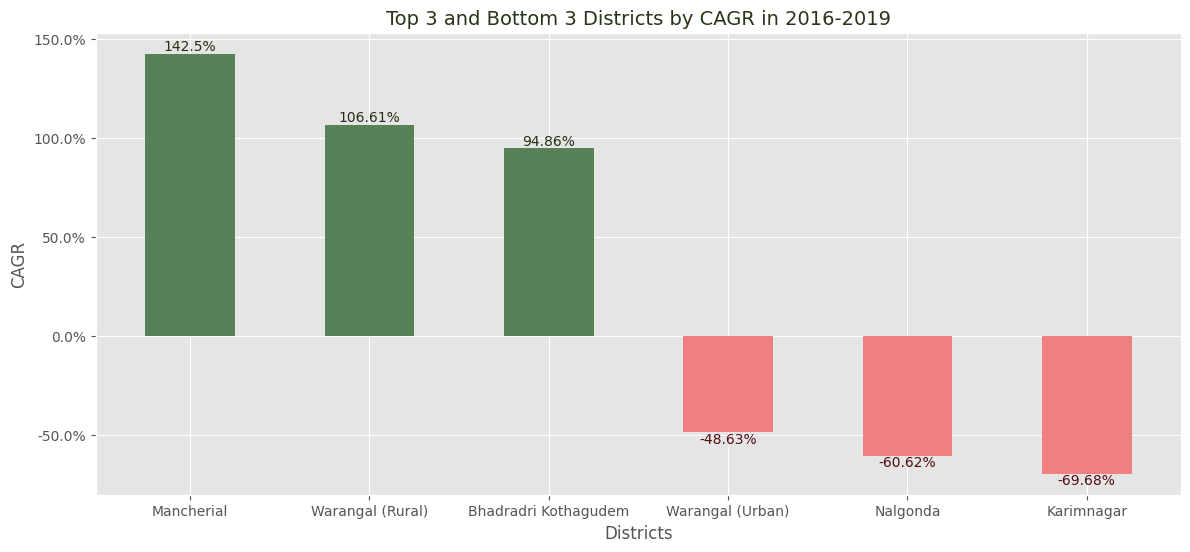

In [299]:
fig, ax = plt.subplots(figsize=(14,6))
top3 = df.head(3)
bottom3 = df.tail(3)
ax.bar(top3.district, height=top3['CAGR'], width=.5, color='#588157')
ax.bar(bottom3.district, height=bottom3['CAGR'], width=.5, color='#f08080')

for i, txt in enumerate(top3['CAGR']):
    ax.annotate('{}%'.format(txt), (i, txt), color='#243010', fontsize=10, ha='center', va='bottom')

for i, txt in enumerate(bottom3['CAGR']):
    ax.annotate('{}%'.format(txt), (i+3, txt), color='#540b0e', fontsize=10, ha='center', va='top')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(x) + '%' ))
ax.set_xlabel('Districts', fontdict={'fontsize': 12})
ax.set_ylabel('CAGR', fontdict={'fontsize': 12})

ax.set_title('Top 3 and Bottom 3 Districts by CAGR in 2016-2019', fontdict={'fontsize': 14, 'color': '#283618'})
plt.show()

`Karimnagar` district faced the major drop in CAGR while `Mancherial` became the choice of the visitors.

### Question 4:
**What are the peak and low seasons for Hyderabad based on the data from 2016-2019?**

In [220]:
def monthly_domestic_visitors_by_district(district):
    visitors_district_month = dv.groupby(['district', 'month'])['visitors'].sum().reset_index()

    key = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
    visitors_district_month.sort_values(by='month', inplace=True, key=lambda x: x.map(key))
    
    vdm_district = visitors_district_month[visitors_district_month['district']==district]

    height = vdm_district['visitors'].max()
    if height == 0:
        return None

    dividor = 1_000_000 if height / 10_000_000 > 1 else (1_000 if height / 10_000 >1 else 1)
    notation = 'M' if height / 10_000_000 > 1 else ('K' if height / 10_000 > 1 else '') 

    fig, ax = plt.subplots(figsize=(12,6))


    ax.plot(vdm_district['month'], 
            vdm_district['visitors'], 
            color='#e63946', 
            marker='o', 
            markersize=6, 
            markerfacecolor='#f1faee', 
            markeredgecolor='#e63946', 
            linewidth=2)
    
    ax.set_ylabel("Visitor Count")
    ax.set_xlabel("Month")
    ax.set_xticklabels(vdm_district['month'], fontdict={'fontsize': 9, 'color': '#222823'})
    ax.set_ylim(0, height + height * 0.1)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x/dividor), ',') + notation ))

    x = 0
    for i, txt in enumerate(vdm_district['visitors']):
        ax.annotate('{:,.1f}{}'.format((txt/dividor), notation ), (x + 0.1, txt), color='#001427', fontsize=10, ha='left', va='bottom', fontweight='bold')
        x+=1

    plt.title(f'Accumulated Number of Domestic Visitors in {district.upper()} district in {dv["date"].dt.year.min()} - {dv["date"].dt.year.max()} (Monthly)',
                fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': '#283618'})
    plt.tight_layout()
    plt.plot()

In [293]:
def monthly_domestic_visitors_by_district_throughout(district, data):
    visitors = data.copy()
    vdm_district = visitors[visitors['district']==district]
    visitors = vdm_district.groupby(['date'])['visitors'].sum().reset_index()
    visitors.sort_values(by='date', inplace=True)

    height = visitors['visitors'].max()
    if height == 0:
        return None

    dividor = 1_000_000 if height / 10_000_000 > 1 else (1_000 if height / 10_000 >1 else 1)
    notation = 'M' if height / 10_000_000 > 1 else ('K' if height / 10_000 > 1 else '') 

    fig, ax = plt.subplots(figsize=(12,6))

    quarterly = visitors.groupby(pd.Grouper(key='date', freq='Q'))['visitors'].sum().reset_index()
    
    ax.plot(visitors['date'], 
            visitors['visitors'], 
            color='#e63946', 
            # marker='o', 
            # markersize=10, 
            # markerfacecolor='#f1faee', 
            # markeredgecolor='#e63946', 
            linewidth=2)
    
    # ax2 = ax.twinx()

    ax.set_ylabel("Visitor Count")
    ax.set_xlabel("Date")
    ax.set_ylim(0, height+ height * 0.1)
    ax.set_xticklabels(visitors['date'], fontdict={'fontsize': 9, 'color': '#222823'}, rotation=0)
    ax.set_yticklabels(np.arange(0, height, 100_000), fontdict={'fontsize': 9, 'color': '#222823'})
    ax.set_ylim(0, height + height * 0.1)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x/dividor), ',') + notation ))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    
    arrow = dict(arrowstyle='-|>', color='#001427', linewidth=1)

    x, this_quarter = 0, 0
    for i, txt in enumerate(visitors['visitors']):
        this_quarter += txt

        if i%3 == 0:
            Q = visitors.iloc[i]['date'].quarter
            ax.plot([visitors['date'].iloc[i], visitors['date'].iloc[i]], [0, this_quarter-this_quarter*0.1], color='#001427', linestyle='--', linewidth=1)
            ax.annotate('{:,.1f}{}(Q{})'.format(this_quarter/dividor, notation, Q ), 
                        (visitors['date'].iloc[i], this_quarter),
                        xytext=(visitors['date'].iloc[i], this_quarter),
                        color='#001427', 
                        fontsize=8, 
                        ha='center', 
                        va='top', 
                        # arrowprops=arrow
                        )
            this_quarter = 0
            x+=1

    y = visitors['visitors'].max()
    x = visitors.iloc[16]['date']
    ax.text(x,y,'Height of dashed line (--) is the toal number of visitors by the end of the quarter')

    fig.autofmt_xdate()
    plt.title(f'Monthly Number of Domestic Visitors Count in {district.upper()} district from {visitors.date.dt.year.min()} - {visitors.date.dt.year.max()}', 
                fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': '#283618'})
    plt.plot()

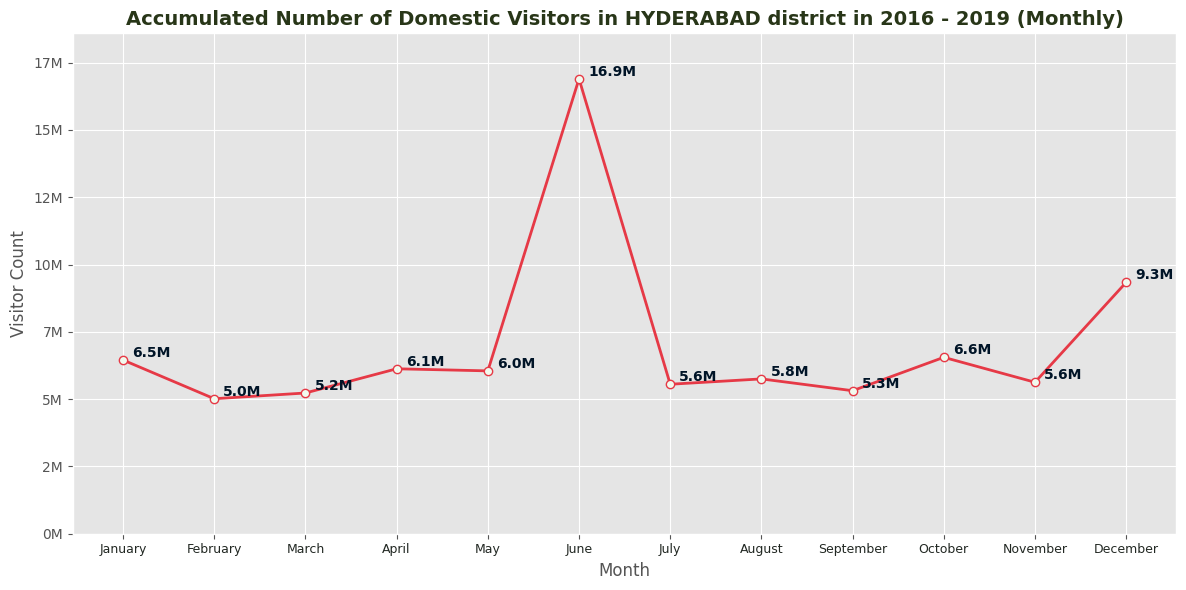

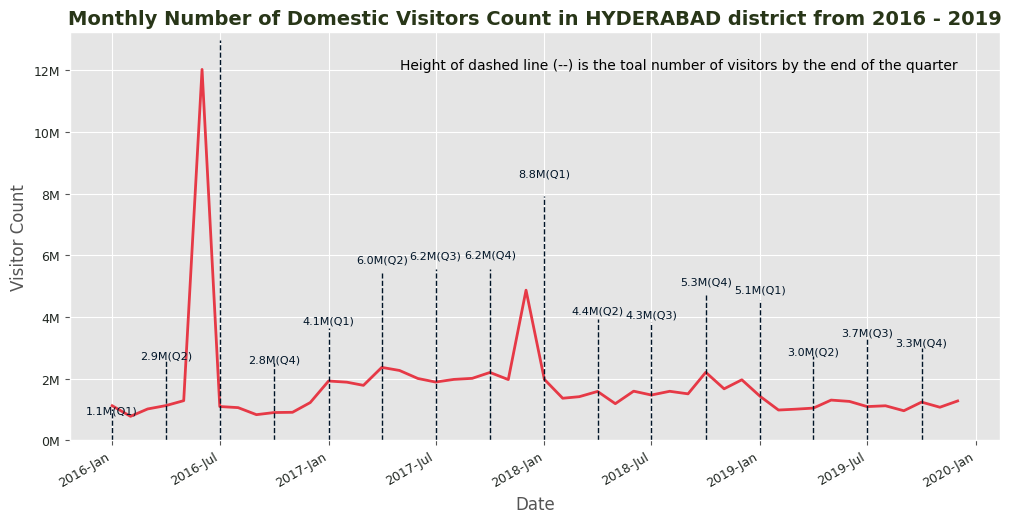

In [294]:
DISTRICT = 'Hyderabad'
monthly_domestic_visitors_by_district(DISTRICT)
monthly_domestic_visitors_by_district_throughout(DISTRICT, dv)

There has been increasing number of tourists in the first Quarter of each year. The number of tourists remain almost consistent in the remaining quarters. 

In [305]:
def bar_graph_annual_visitors_count_by_district(dataset):
    grouped_data = dataset.groupby(['district'])['visitors'].sum().reset_index()
    grouped_data['visitors'] = grouped_data['visitors'].astype('int64')
    grouped_data = grouped_data.sort_values(by='visitors', ascending=False).head(10)
    grouped_data.reset_index(drop=True, inplace=True)
    height = grouped_data['visitors'].max()
    year = dataset['date'].dt.year.unique()[0]

    fig, ax = plt.subplots()
    plt.style.use('ggplot')
    ax.figure.set_size_inches(10, 6)
    bar = ax.bar(x='district', height='visitors', data=grouped_data, width=.5, align='center', color='#e63946')
    # ax.bar_label(bar, labels=grouped_data['visitors'], fmt='{:,%d}', color='#0f4c5c', font={'size':10,})
    ax.set_xlabel('District')
    ax.tick_params(axis='x', labelrotation = 23, labelsize=9)
    ax.set_ylabel('Visitors')

    ax.set_yticklabels(np.arange(0,grouped_data['visitors'].max()+2_000_000, 2_000_000), fontdict={'fontsize': 9, 'color': '#0f4c5c'})
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',') + 'M' ))
    x=0
    for i, txt in enumerate(grouped_data['visitors']):
        ax.annotate('{:.1f}M'.format(txt/1_000_000), (x, txt), color='#0d0a0b', fontsize=12, ha='left', va='baseline') 
        x+=1
    ax.set_title(f'Top 10 Districts by Annual Number of Visitors Count in {year}', fontdict={'fontsize': 20, 'color': '#5f0f40'})
    plt.tight_layout()
    plt.show()

#### Question 6:
**List the top 5 and bottom 5 districts withe population to footfall ratio in 2019.**

ratio = total visitors / total residents in the given area

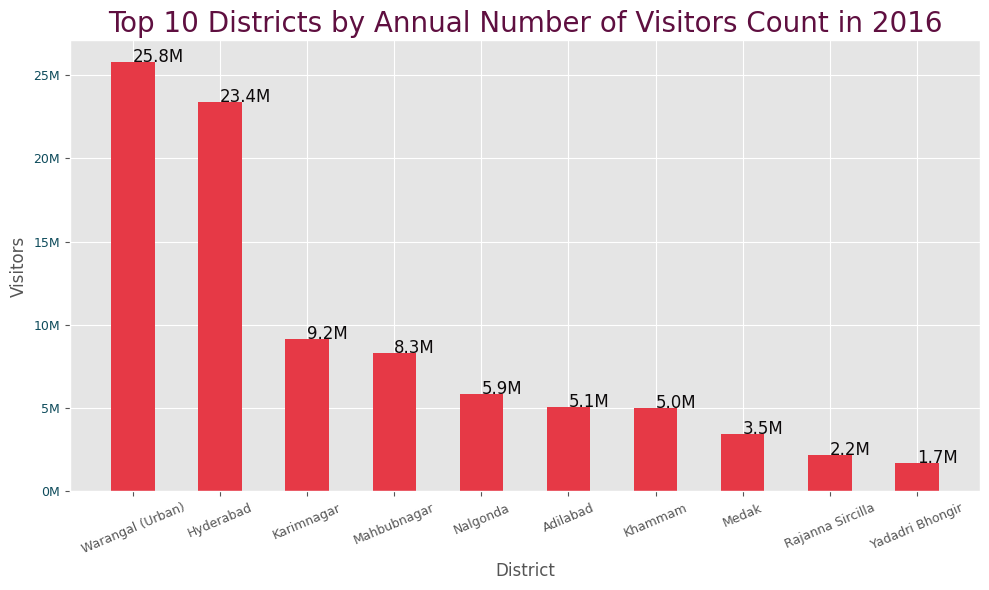

In [306]:
bar_graph_annual_visitors_count_by_district(dv_16)

### Question 7: 
**What will be the projected number of domestic and foreign visitors in the year 2025?**

#### Domestic Visitors

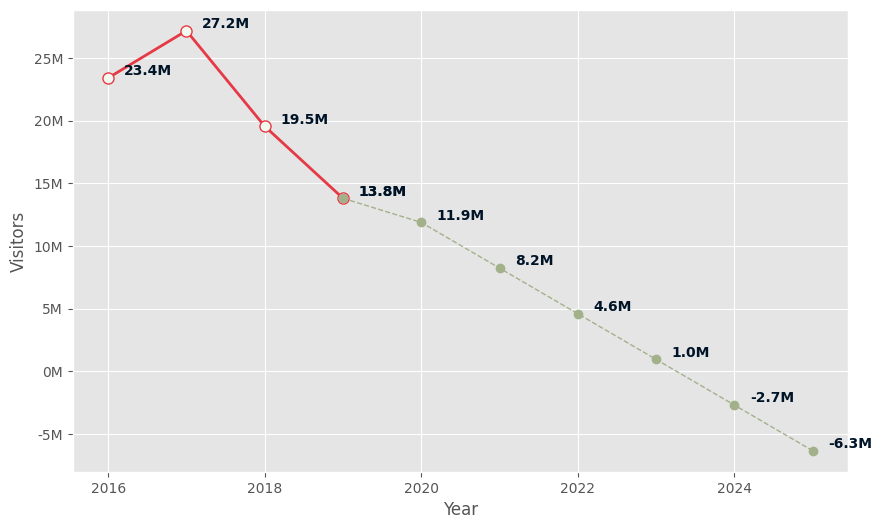

In [307]:
hyd = dv[dv['district']=='Hyderabad'].groupby(['year'])['visitors'].sum().reset_index()
hyd['pct_change'] = hyd['visitors'].pct_change().fillna(0)

fit_visitors = np.polyfit(hyd.year, hyd.visitors, 1)
fit_pc = np.polyfit(hyd.year, hyd['pct_change'], 1)

pc_fn = np.poly1d(fit_pc)
visitors_fn = np.poly1d(fit_visitors)

years = [2020, 2021, 2022, 2023, 2024, 2025]

projection = visitors_fn(years).astype('int64')
projection_pc = pc_fn(years)

projected_visitors = pd.DataFrame({'year': years, 'visitors': projection, 'pct_change':projection_pc})
projected_visitors=pd.concat([hyd[hyd['year']==2019],projected_visitors], ignore_index=True)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(hyd['year'], 
        hyd['visitors'], 
        color='#e63946', 
        marker='o', 
        markersize=8, 
        markerfacecolor='#f1faee', 
        markeredgecolor='#e63946', 
        linewidth=2
        )

ax.plot(
    projected_visitors['year'], 
    projected_visitors['visitors'], 
    color='#a3b18a', 
    marker = 'o',
    linewidth=1, 
    linestyle='--')

hyd = pd.concat([hyd, projected_visitors], ignore_index=True)

for year, visitors in zip(hyd.year.values, hyd.visitors.values):
    ax.annotate('{:,.1f}{}'.format(visitors/1_000_000, 'M' ), 
                (year, visitors),
                xytext=(year+0.2, visitors),
                color='#001427', 
                fontsize=10, 
                ha='left', 
                va='bottom', 
                fontweight='bold',
                )

ax.set_xlabel('Year')
ax.set_ylabel('Visitors')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',') + 'M' ))
plt.show()

#### Foreign Visitors

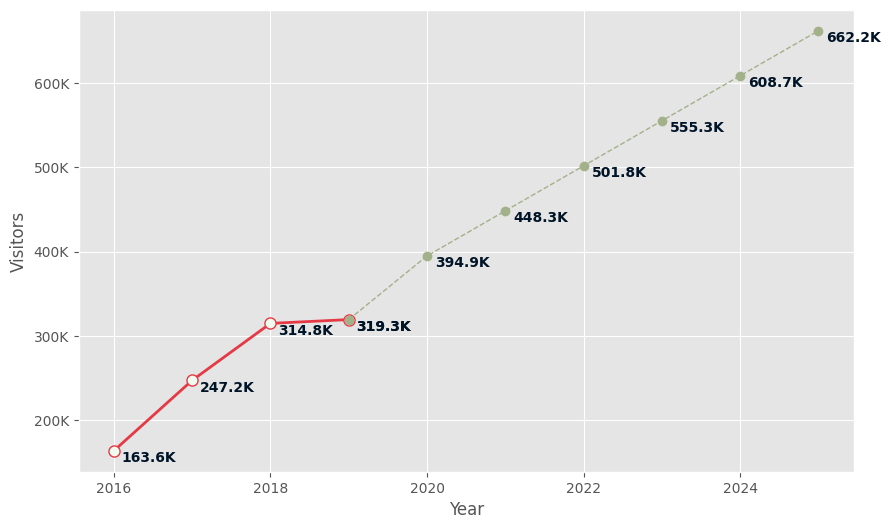

In [310]:
hyd_fv = fv[fv['district']=='Hyderabad'].groupby(['year'])['visitors'].sum().reset_index()

fvisitors = np.polyfit(hyd_fv.year, hyd_fv.visitors, 1)

fvisitors_fn = np.poly1d(fvisitors)

years = [2020, 2021, 2022, 2023, 2024, 2025]

projection_fv = fvisitors_fn(years).astype('int64')
projected_fvisitors = pd.DataFrame({'year': years, 'visitors': projection_fv})
projected_fvisitors = pd.concat([hyd_fv[hyd_fv['year']==2019],projected_fvisitors], ignore_index=True)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(hyd_fv['year'], 
        hyd_fv['visitors'], 
        color='#e63946', 
        marker='o', 
        markersize=8, 
        markerfacecolor='#f1faee', 
        markeredgecolor='#e63946', 
        linewidth=2
        )

ax.plot(
    projected_fvisitors['year'], 
    projected_fvisitors['visitors'], 
    color='#a3b18a', 
    marker = 'o',
    linewidth=1, 
    linestyle='--')

hyd_fv = pd.concat([hyd_fv, projected_fvisitors], ignore_index=True)

for year, visitors in zip(hyd_fv.year.values, hyd_fv.visitors.values):
    ax.annotate('{:,.1f}{}'.format(visitors/1_000, 'K' ), 
                (year, visitors),
                xytext=(year+0.1, visitors),
                color='#001427', 
                fontsize=10, 
                ha='left', 
                va='top', 
                fontweight='bold',
                )

ax.set_xlabel('Year')
ax.set_ylabel('Visitors')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x/1_000), ',') + 'K' ))
plt.show()

### Question 8:
**Estimate the projected revenue of Hyderabad based on average spend per tourist**\
*International Tourists `Rs 5,600`*\
*Domestic Tourists `Rs 1,200`*

In case of International tourists projection, we cannot estimate the revenue as the estimation is in negative number of `International Tourists` for year 2025.

In [ ]:
Revenue_Domestic_2025 = hyd_fv[hyd_fv['year']==2025]['visitors'] *1200
Revenue_Domestic_2025

10    794623200.0
Name: visitors, dtype: float64

#### Conclusion:
The revenue from International Visitors for year 2025 is expected to be  `Rs.79,46,23,200 `

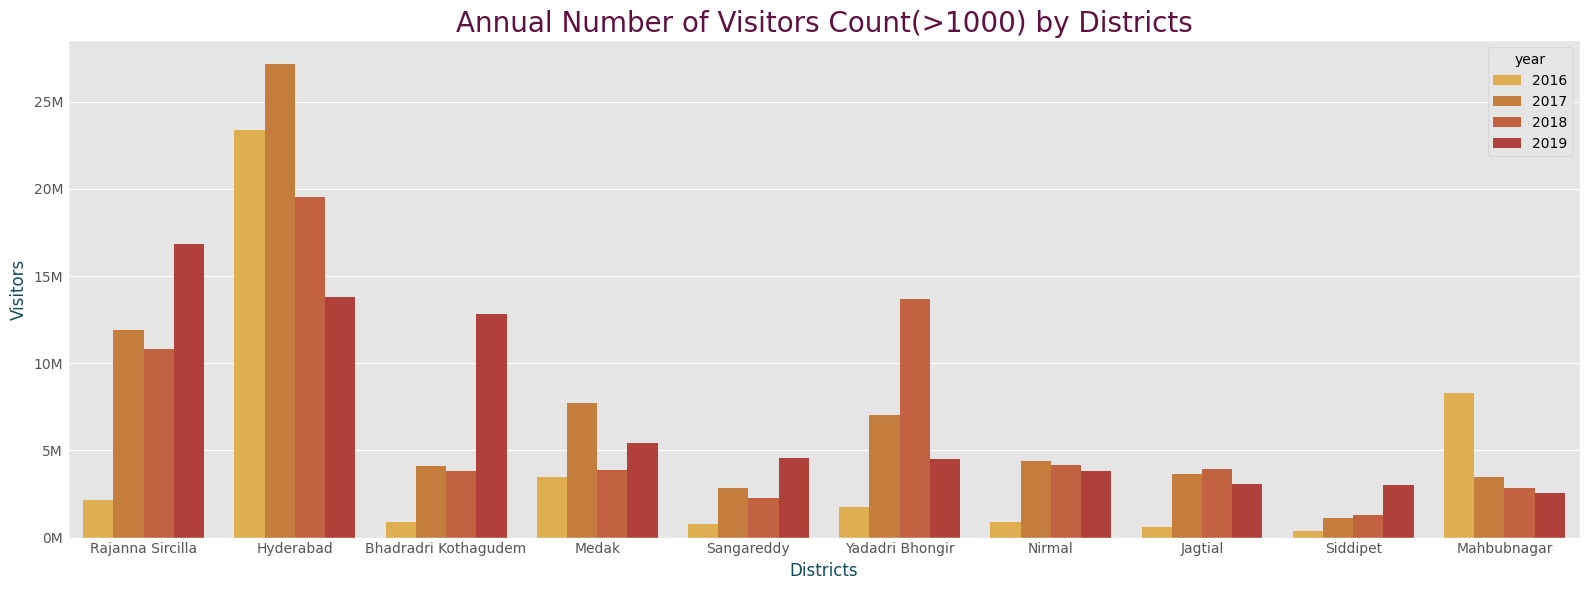

In [ ]:
plt.style.use('ggplot')

g = dv[dv['visitors']>1000].groupby(['district', 'year'])['visitors'].sum().reset_index().sort_values(by=['year','visitors'], ascending=False)

dist = g['district'].unique()[:10]
g = g[g['district'].isin(dist)]

fig, ax = plt.subplots(figsize=(16, 6))

# palette = ['#8da9c4', '#134074', '#13315c', '#0b2545']

palette = ['#f7b538', '#db7c26', '#d8572a', '#c32f27']

sns.barplot(x='district', y='visitors', hue='year', data=g, ax=ax, palette=palette)

# visitors = ['{:,.2f} M'.format(x/1_000_000) for x in g['visitors'].values]
# for i, txt in enumerate(visitors):
#     ax.annotate(txt, (g['year'][i], 60_000_000), color='#003049', fontsize=10) 

ax.tick_params(axis='x', labelsize=10)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',') + 'M' ))
ax.set_xlabel('Districts', fontdict={'fontsize': 12, 'color': '#0f4c5c'})
ax.set_ylabel('Visitors', fontdict={'fontsize': 12, 'color': '#0f4c5c'})
plt.title('Annual Number of Visitors Count(>1000) by Districts', fontdict={'fontsize': 20, 'color': '#5f0f40'})
plt.tight_layout()
plt.show()

In [ ]:
def do_not_use(dataset):
    df = dataset[dataset['visitors']>1_000]

    fig, axd = plt.subplot_mosaic([df.district.unique().tolist()], figsize=(16, 4), sharey=True)
    index = pd.MultiIndex.from_product([df.district.unique().tolist()[:10], df.year.unique().tolist()], names=['district', 'year'])
    districts = df.district.unique().tolist()
    colors = ['#e63946', '#283618', '#023047', '#e76f51']
    rng = np.random.default_rng(0)


    data = df.groupby(['district', 'year'])['visitors'].sum().sort_index()[:40]

    for district, group in data.groupby('district'):
        group = group.droplevel('district')
        bar = axd[district].bar(x=group.index.astype(str), height=group, width=.5, align='center', color=colors)
        axd[district].set_xticklabels(group.index.astype(str), fontdict={'fontsize': 9, 'color': '#0f4c5c'})
        axd[district].set_yticklabels(np.arange(0,group.max()+2_000_000, 2_000_000), fontdict={'fontsize': 9, 'color': '#0f4c5c'})
        plt.setp(axd[district].get_xticklabels(), size='small')
        
    for ax in axd.values():
        ax.spines[:].set_visible(False)
        ax.yaxis.set_tick_params(left=False)
        ax.xaxis.set_tick_params(bottom=False)
        ax.margins(y=.25)
        ax.yaxis.grid(color=ax.get_facecolor())

    axd[district].legend(
        bar,
        group.index,
        loc='upper right', 
        bbox_to_anchor=(1, 1),
        title='Year',
    )

    from matplotlib.patches import ConnectionPatch
    conn = ConnectionPatch(
        xyA=(0, 0), coordsA=fig.axes[0].transAxes,
        xyB=(1, 0), coordsB=fig.axes[-1].transAxes,
        lw=ax.spines['bottom'].get_linewidth()
    )
    fig.add_artist(conn)

In [ ]:


visitors_year = dv.groupby(['year'])['visitors'].sum().reset_index()
visitors_year.sort_values(by='year', ascending=True, inplace=True)

visitors_month = dv.groupby(['month'])['visitors'].sum().reset_index()
visitors_month.sort_values(by='month', ascending=True, inplace=True)

visitors_district_month = dv.groupby(['district', 'month'])['visitors'].sum().reset_index()
visitors_district_month.sort_values(by='month', ascending=False, inplace=True)

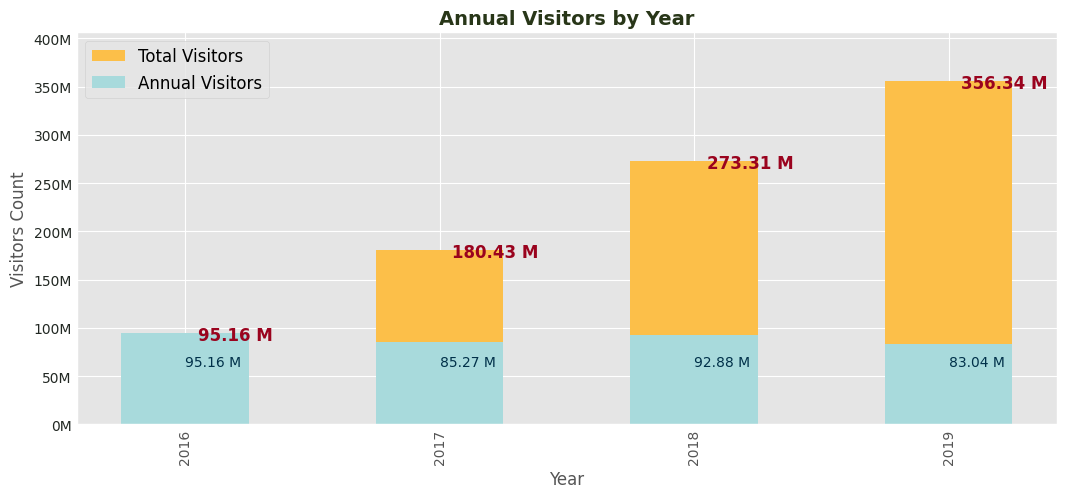

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

cumsum = visitors_year['visitors'].cumsum()
height = cumsum.max()
ax.set_ylim(0, height + 50_000_000)
# ax.plot(visitors_year['year'], cumsum, color='#003049', marker='o', markersize=10, markerfacecolor='#979dac', markeredgecolor='#f46036', linewidth=2)
ax.bar(visitors_year['year'], cumsum, width=.5, color='#fcbf49')
ax.bar(visitors_year['year'], visitors_year['visitors'], width=.5, color='#a8dadc')

formatted_weights = ['{:,.2f} M'.format(x/1_000_000) for x in cumsum]

for i, txt in enumerate(formatted_weights):
    ax.annotate(txt, (visitors_year['year'][i]+0.05, cumsum[i]), fontweight='bold', color='#9a031e', fontsize=12, ha='left', va='center_baseline') 

# plt.bar_label(bar, labels=visitors_year['visitors'], label_type='center',color='#ffedd8', rotation=30, font={'size':12})

visitors = ['{:,.2f} M'.format(x/1_000_000) for x in visitors_year['visitors'].values]
for i, txt in enumerate(visitors):
    ax.annotate(txt, (visitors_year['year'][i], 60_000_000), color='#003049', fontsize=10) 

plt.xticks(ticks=visitors_year['year'],rotation=90)
ax.set_yticklabels(np.arange(0,height+100_000, 1_000_000), fontdict={'fontsize': 10, 'color': '#222823'})
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',') + 'M' ))

ax.set_xlabel('Year')
ax.set_ylabel('Visitors Count')

ax.legend(['Total Visitors', 'Annual Visitors'], loc='upper left', fontsize=12)

plt.title('Annual Visitors by Year', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': '#283618'})
plt.show()

In [ ]:
def monthly_foreign_visitors_by_district_throughout(district, data):
    visitors = data.copy()
    vdm_district = visitors[visitors['district']==district]
    visitors = vdm_district.groupby(['date'])['visitors'].sum().reset_index()
    visitors.sort_values(by='date', inplace=True)

    height = visitors['visitors'].max()
    if height == 0:
        return None

    fig, ax = plt.subplots(figsize=(12,6))
    # ax2 = ax.twinx()
    # ax2.yaxis.set_visible(False)
    quarterly = visitors.groupby(pd.Grouper(key='date', freq='Q'))['visitors'].sum().reset_index()
    
    ax.plot(visitors['date'], 
            visitors['visitors'], 
            color='#e63946', 
            marker='o', 
            markersize=10, 
            markerfacecolor='#f1faee', 
            markeredgecolor='#e63946', 
            linewidth=2)

    ax.set_ylabel("Visitor Count")
    ax.set_xlabel("Date")
    ax.set_xticklabels(visitors['date'], fontdict={'fontsize': 9, 'color': '#222823'}, rotation=0)
    ax.set_yticklabels(np.arange(0, height, 1_000), fontdict={'fontsize': 9, 'color': '#222823'})
    ax.set_ylim(0, height+ (height*0.1))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',' )))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    x = 0

    arrow = dict(arrowstyle='-|>', color='#001427', linewidth=1)
    for i, txt in enumerate(visitors['visitors']):
        if i%4 == 0:
            # print(visitors['date'].iloc[i], txt)
            ax.annotate('{:,.0f}'.format(int(txt)), 
                        (visitors['date'].iloc[i], txt),
                        xytext=(visitors['date'].iloc[i], txt +(height*0.1)),
                        color='#001427', 
                        fontsize=10, 
                        ha='center', 
                        va='bottom', 
                        fontweight='bold',
                        arrowprops=arrow
                        )
            

            x+=1
    # for i, txt in enumerate(quarterly['visitors']):
    #     ax2.annotate(txt, (quarterly['date'].iloc[i], txt), fontweight='bold', color='#9a031e', fontsize=8, ha='left', va='center_baseline')
        
    fig.autofmt_xdate()
    plt.title(f'Monthly Number of Foreign Visitors Count in {district.upper()} district from {visitors.date.dt.year.min()} - {visitors.date.dt.year.max()}', 
                fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': '#283618'})
    plt.plot()


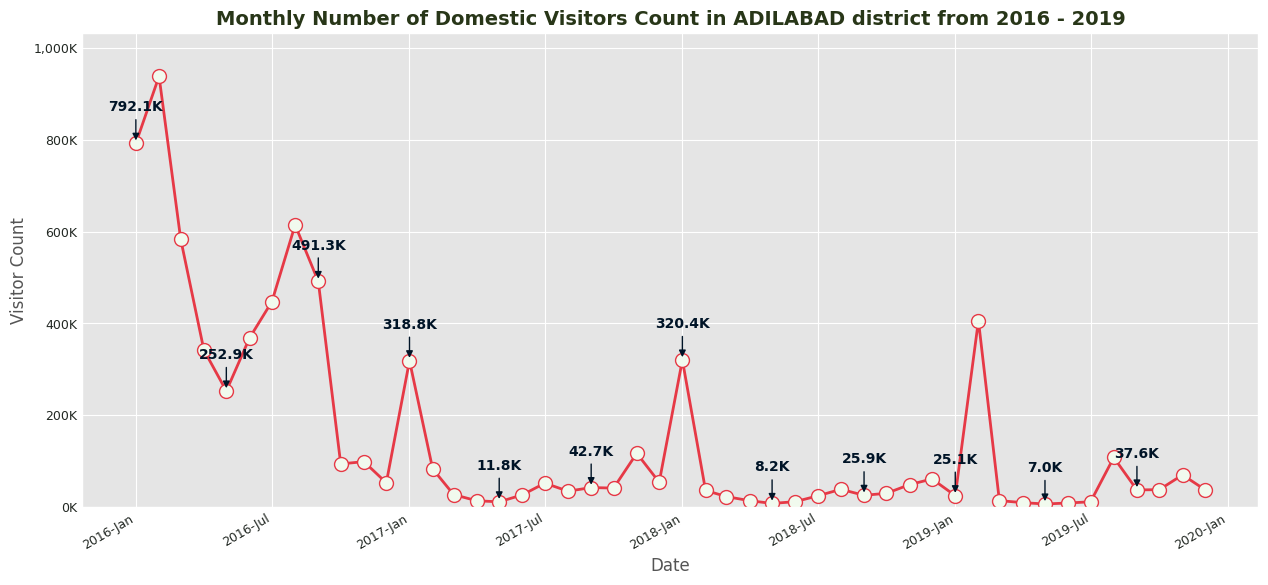

In [ ]:
monthly_domestic_visitors_by_district_throughout('Adilabad', dv)

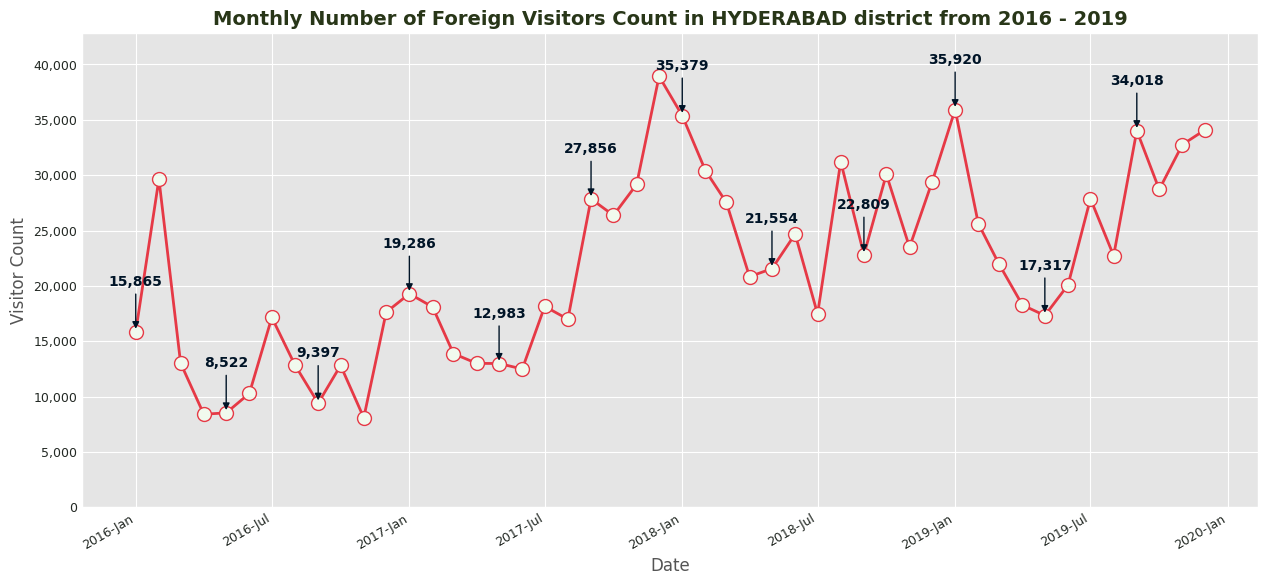

In [ ]:
DISTRICT = 'Hyderabad'
monthly_foreign_visitors_by_district_throughout(DISTRICT, fv)

In [ ]:
yearly = dv.groupby(['district','year'])['visitors'].sum().sort_values(ascending=False).unstack().reset_index()
yearly.replace(0, np.nan, inplace=True)
yearly.dropna(axis=0, thresh=3, inplace=True)


In [ ]:
def increaging_visitors(df):
    increasing = []
    for i, row in df.iterrows():
        values = row.values[1:].tolist()
        if values[0] < values[1] < values[2] or values[1] < values[2] < values[3]:
            increasing.append(True)
        else:
            increasing.append(False)
    return increasing

In [ ]:
def decreasing_visitors(df):
    decreasing = []
    for i, row in df.iterrows():
        values = row.values[1:].tolist()
        if values[0] > values[1] > values[2] or values[1] > values[2] > values[3]:
            decreasing.append(True)
        else:
            decreasing.append(False)
    return decreasing

In [ ]:
increaging =increaging_visitors(yearly)
decreasing = decreasing_visitors(yearly)

In [ ]:
yearly['increasing'] = pd.Series(increaging)
yearly['decreasing'] = pd.Series(decreasing)

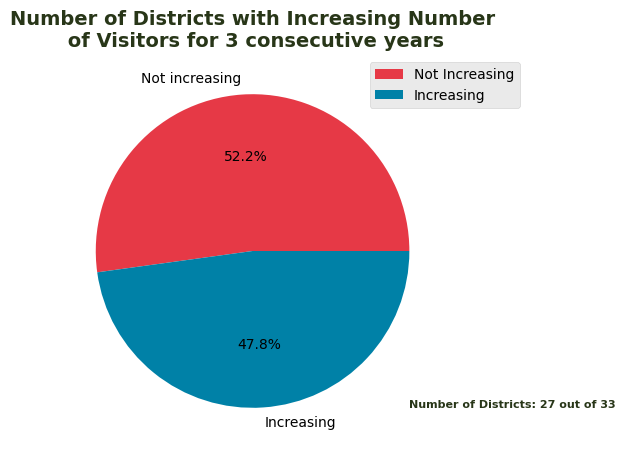

In [ ]:
plt.figure(figsize=(4,4))
plt.pie(yearly['increasing'].value_counts(), radius=1, labels=['Not increasing', 'Increasing'], autopct='%1.1f%%', colors=['#e63946', '#0081a7'])
plt.legend(['Not Increasing', 'Increasing'], loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.title('Number of Districts with Increasing Number\n of Visitors for 3 consecutive years', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': '#283618'}, loc='center')
plt.text(1, -1, 'Number of Districts: {} out of {}'.format(yearly.shape[0], len(dv.district.unique())), fontdict={'fontsize': 8, 'fontweight': 'bold', 'color': '#283618'})
plt.show()

In [342]:
all_visitors = pd.merge(fv, dv, on=['date', 'district'], how='inner')
all_visitors.drop(['year_x', 'month_x','month_y', 'year_y','quarter','date'], axis=1, inplace=True)
all_visitors.rename(columns={'visitors_x':'foreign_visitors', 'visitors_y':'domestic_visitors'}, inplace=True)

In [348]:
visitors_total = all_visitors.groupby(['district']).sum().replace(0, np.nan)
visitors_total.dropna(axis=0, inplace=True)
visitors_total['dtof_ratio'] = np.round((visitors_total['domestic_visitors'] / visitors_total['foreign_visitors']),2)
visitors_total.sort_values(by='dtof_ratio', ascending=False, inplace=True)

In [349]:
visitors_total.head(3)

,foreign_visitors,domestic_visitors,dtof_ratio
district,,,
Nirmal,2.0,13315796.0,6657898.00
Jangaon,2.0,826280.0,413140.00
Adilabad,32.0,7321575.0,228799.22


In [350]:
visitors_total.tail(3)

,foreign_visitors,domestic_visitors,dtof_ratio
district,,,
Mulugu,575.0,1819800.0,3164.87
Warangal (Rural),306.0,819162.0,2677.00
Hyderabad,1044898.0,83900960.0,80.30


Population Growth Rate of Telengana for the year 2016-2020 is estimated at 5.4.
Source: https://ruralindiaonline.org/en/library/resource/population-projections-for-india-and-states-2011-2036/

https://www.findeasy.in/districts-in-telangana/
https://www.indiacensus.net/states/telangana